# Topic 1: Price Forecast - Avocado

### Yêu cầu 4: Lựa chọn thị trường tiềm năng

Sau khi thực hiện phân tích yêu cầu 3, chúng ta nhận thấy việc tìm kiếm thị trường tiềm năng để phát triển có thể dựa vào xu hướng tăng của doanh thu trung bình theo mô hình FB Prophet để lựa chọn => chúng ta sẽ tổng quát hóa công việc lên để có thể xem xét và lựa chọn thị trường

## Triển Khai Dự Án

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from math import sqrt

from sklearn.pipeline import  Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

Importing plotly failed. Interactive plots will not work.


In [2]:
import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.2f}'.format

In [3]:
data = pd.read_csv('avocado.csv', index_col=0)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.9+ MB


In [5]:
data.head()

Date  AveragePrice  Total Volume    4046      4225   4770  \
0  2015-12-27          1.33      64236.62 1036.74  54454.85  48.16   
1  2015-12-20          1.35      54876.98  674.28  44638.81  58.33   
2  2015-12-13          0.93     118220.22  794.70 109149.67 130.50   
3  2015-12-06          1.08      78992.15 1132.00  71976.41  72.58   
4  2015-11-29          1.28      51039.60  941.48  43838.39  75.78   

   Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  region  
0     8696.87     8603.62       93.25         0.00  conventional  2015  Albany  
1     9505.56     9408.07       97.49         0.00  conventional  2015  Albany  
2     8145.35     8042.21      103.14         0.00  conventional  2015  Albany  
3     5811.16     5677.40      133.76         0.00  conventional  2015  Albany  
4     6183.95     5986.26      197.69         0.00  conventional  2015  Albany

# Phân tích thị trường dựa trên doanh thu trung bình và FB Prophet

In [7]:
df = data.copy()

In [8]:
#tạo thêm biến doanh thu trung bình
df['AverageRevenue'] = df['AveragePrice'] * df['Total Volume']

<b>xây dựng hàm dự đoán bằng FB Prophet dựa trên AverageRevenue</b>

In [27]:
#xây dựng hàm dự đoán bằng FB Prophet dựa trên AverageRevenue
def hass_future_forecast(data, state, hass_type, y):
    #Select region == total us
    df = data[(data['region'] == state) & (data['type'] == hass_type)]
    #Select needed columns
    df = df[['Date', y]]
    df.columns = ['ds', 'y']
    df.loc[:,'ds'] = pd.to_datetime(df['ds'])
    #Group by date, who analysis cover all two types of hass avocado
    #df = df.groupby(by='ds', ).sum()
    #Scaling data for boost performance and readability
    df['y'] = df['y']/10e6 #Scale to million
    #Reset index for fbprophet
    df = df.reset_index()
    #Fbprophet
    m = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True)
    m.fit(df)
    #Create future stream
    future = m.make_future_dataframe(periods=12, freq='MS', include_history=True)
    #Forecast the unknown
    forecast = m.predict(future)
    #Take a look at the graph
    fig = m.plot(forecast, figsize=(15,6))
    plt.title(state, fontsize=20,color="red")
    fig.show()
    a = add_changepoints_to_plot(fig.gca(), m, forecast)
    #component plot
    #m.plot_components(forecast, figsize=(15,10))
    #plt.show()

<b>test thử với conventional tại California trước đó đã làm</b>

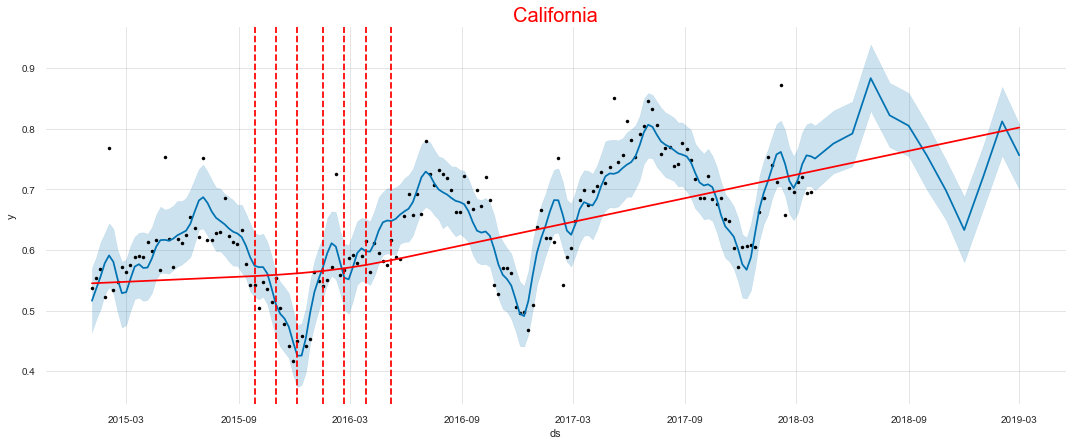

In [28]:
hass_future_forecast(data=df, state = 'California', hass_type='conventional', y = 'AverageRevenue')

### Như vậy ta đã có được cách tổng quát để xem xét 1 thị trường tiềm năng, tiếp theo chúng ta chỉ cần xem trên cả 54 region cho từng type để có thể chọn ra thị trường tiềm năng như mong đợi

In [29]:
state = df['region'].unique()
state

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

### Lựa chọn thị trường cho bơ Organic

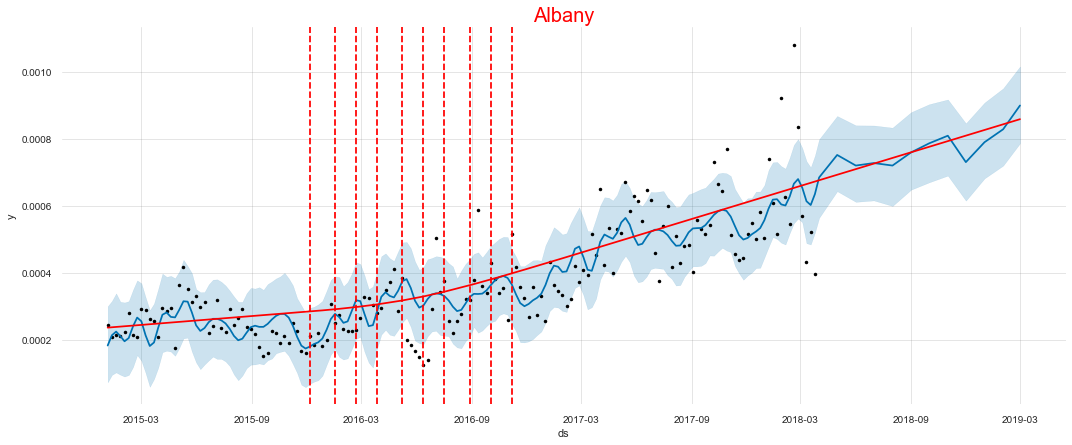

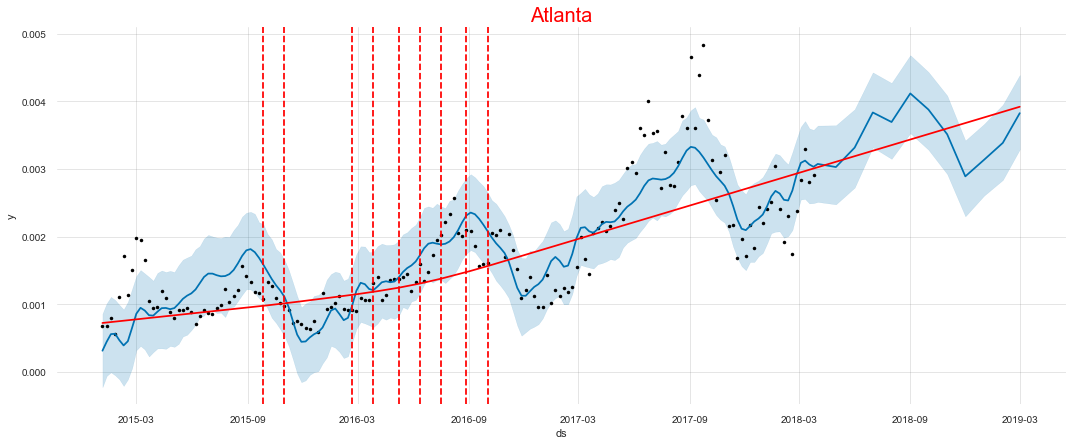

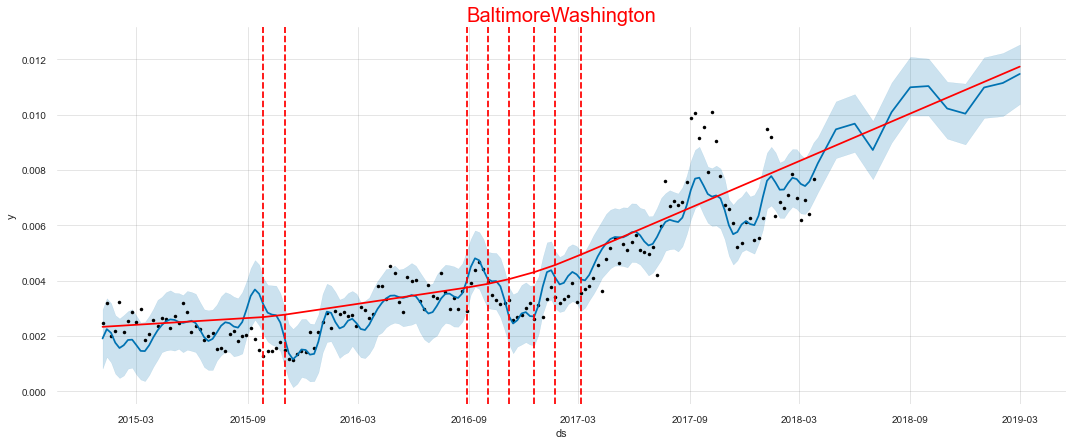

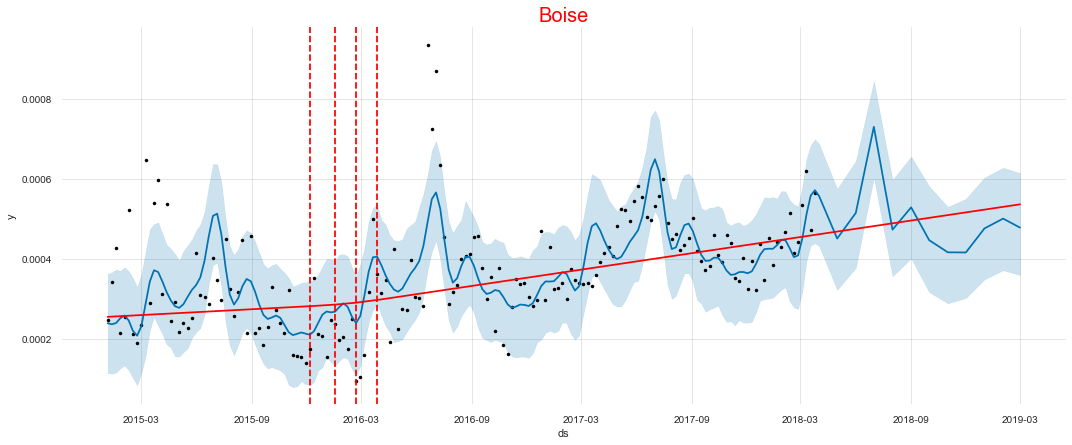

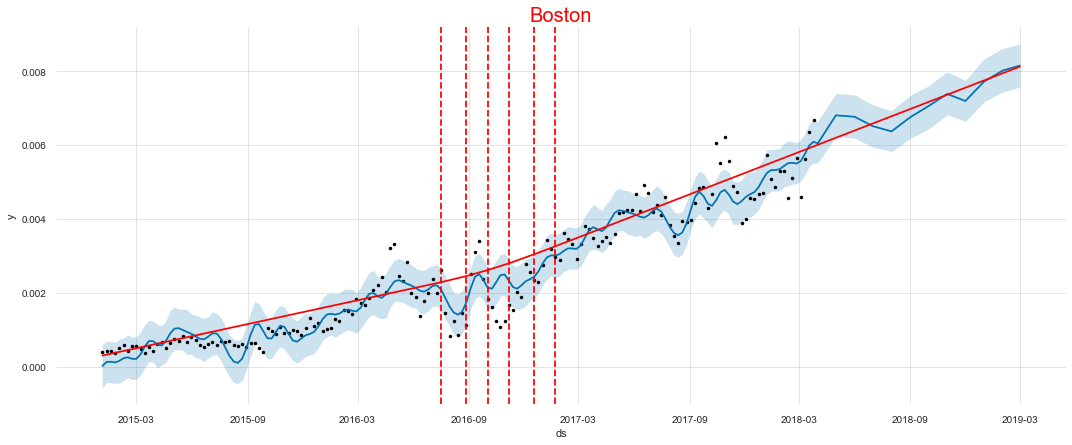

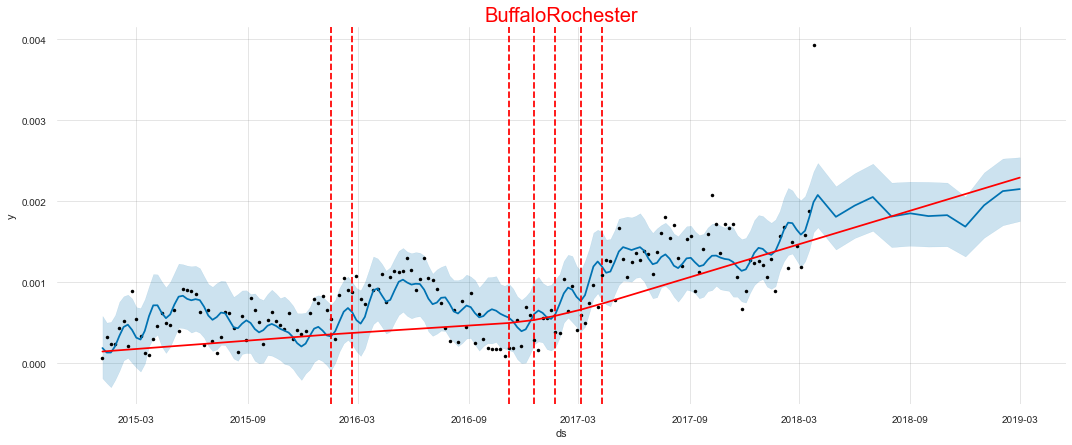

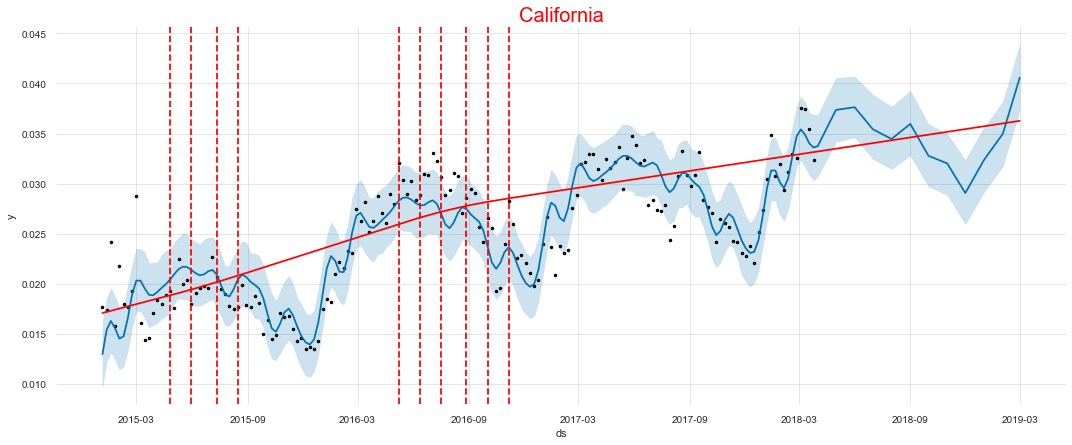

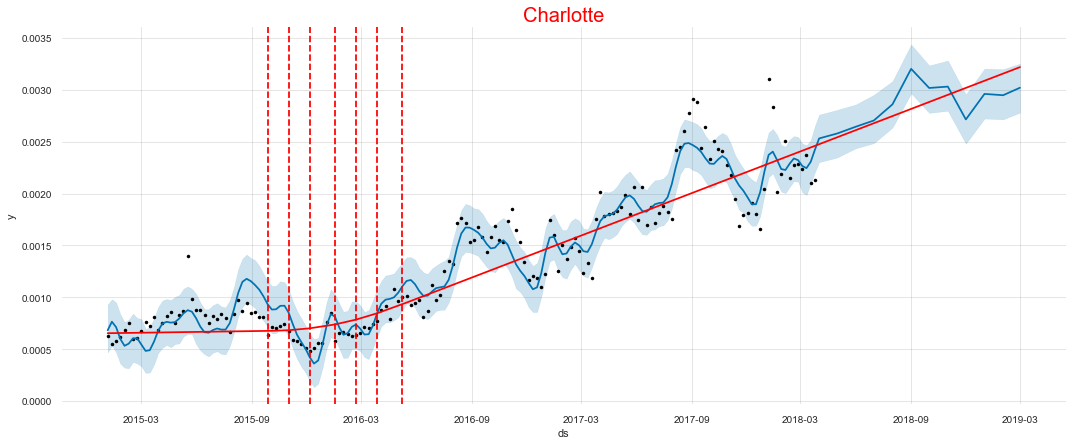

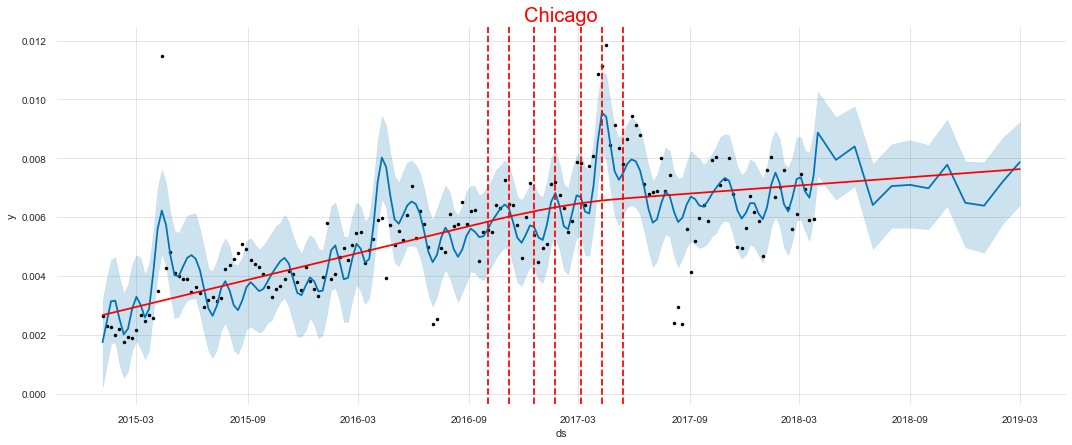

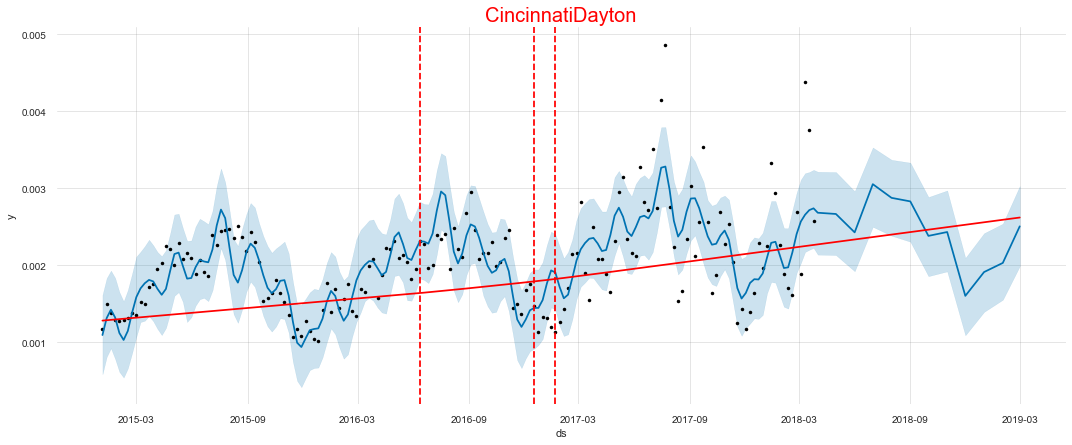

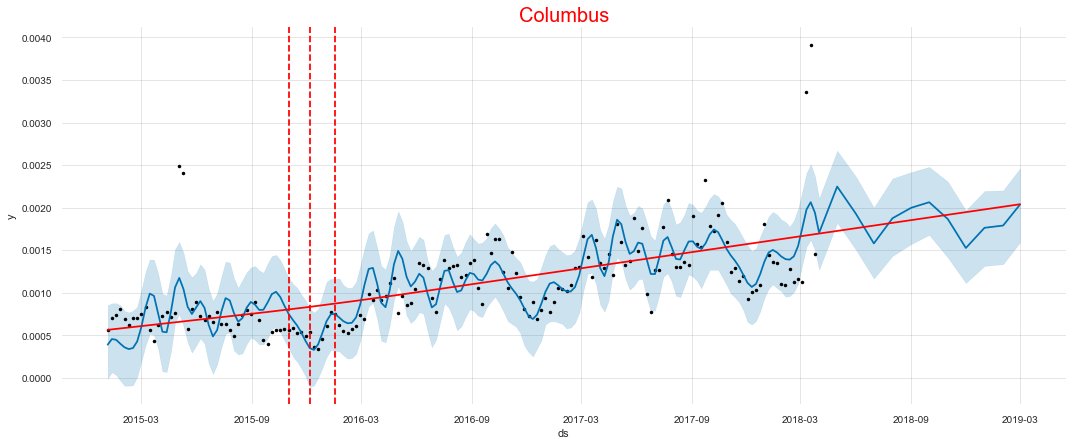

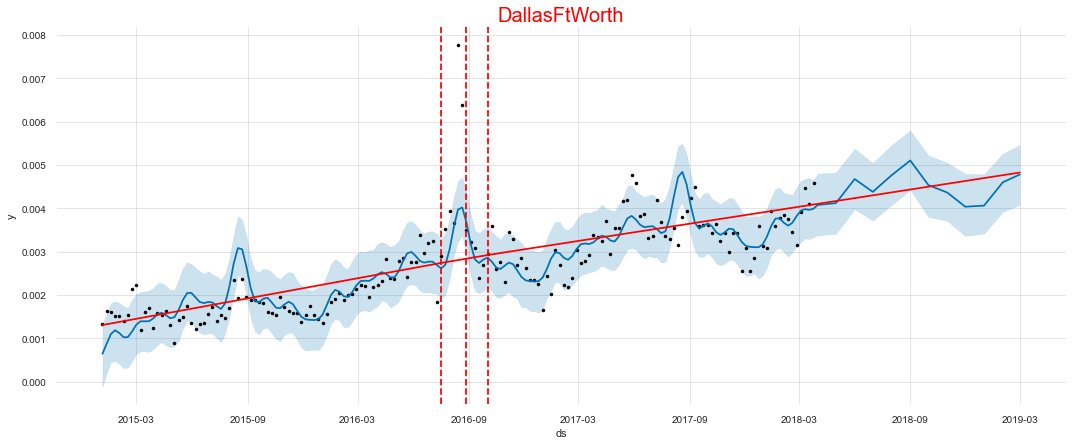

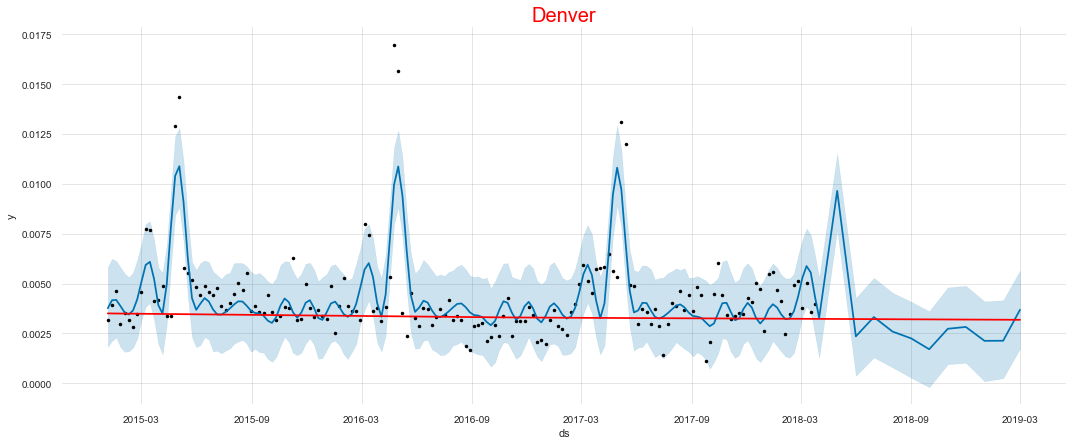

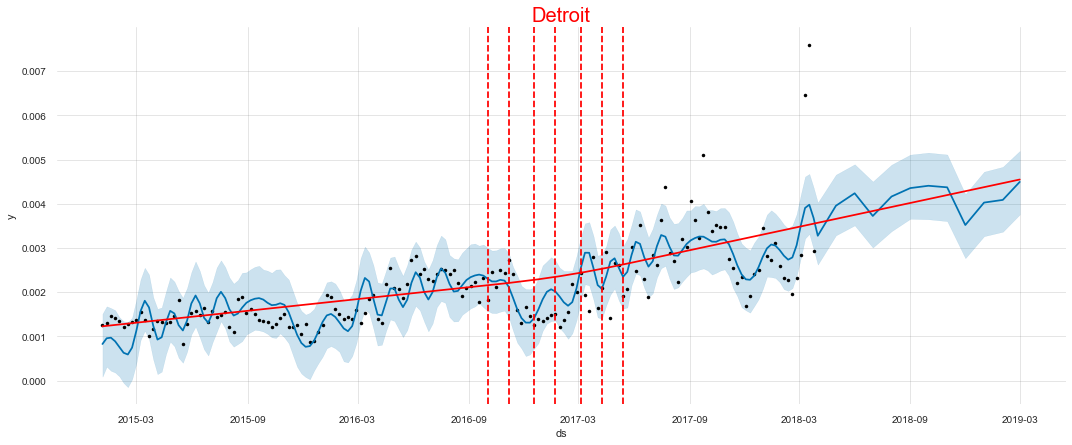

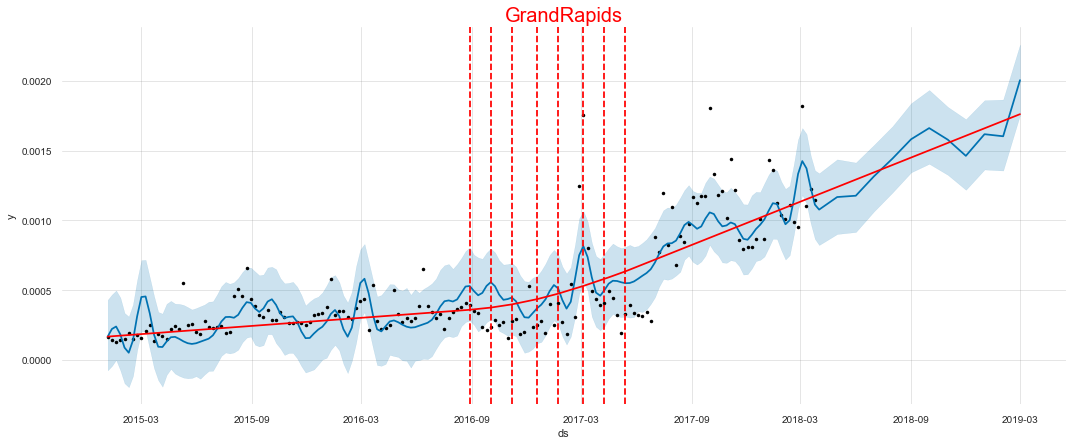

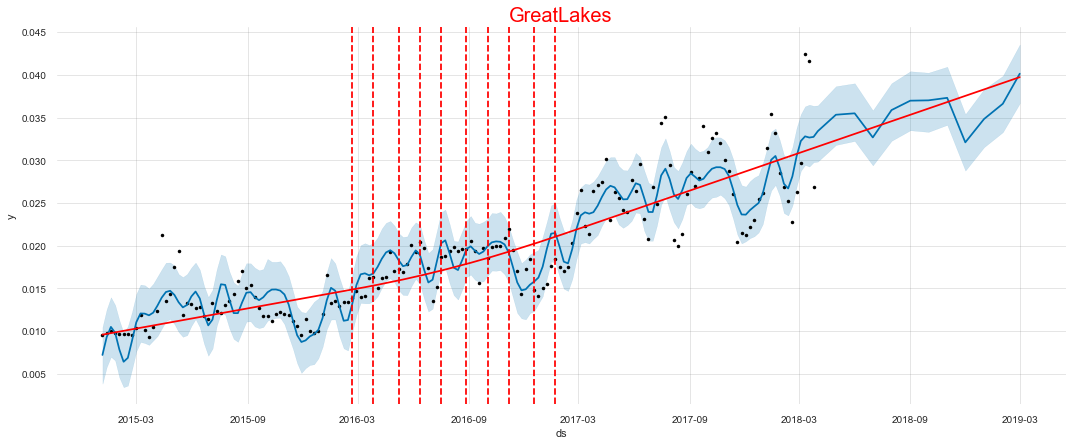

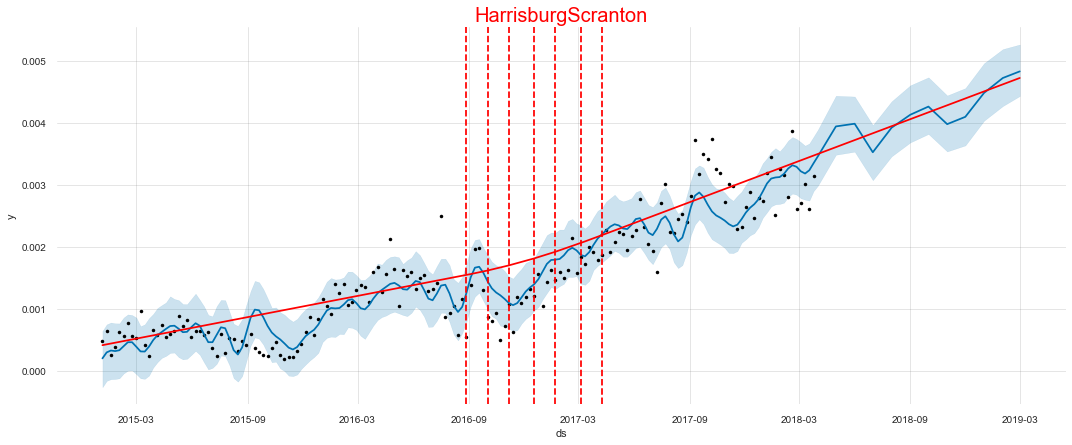

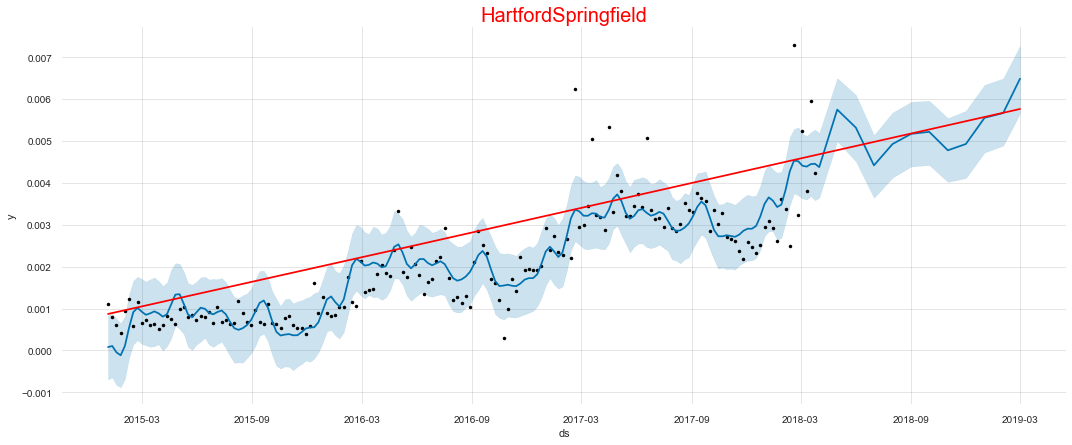

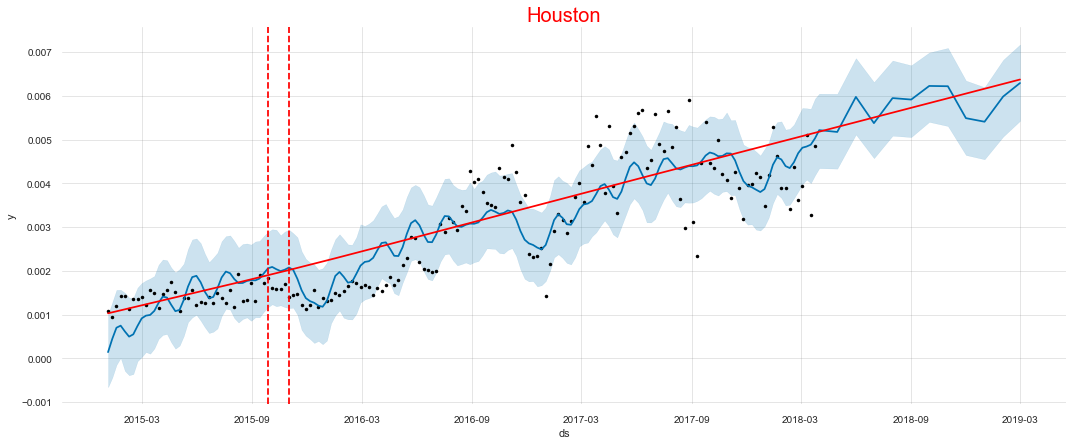

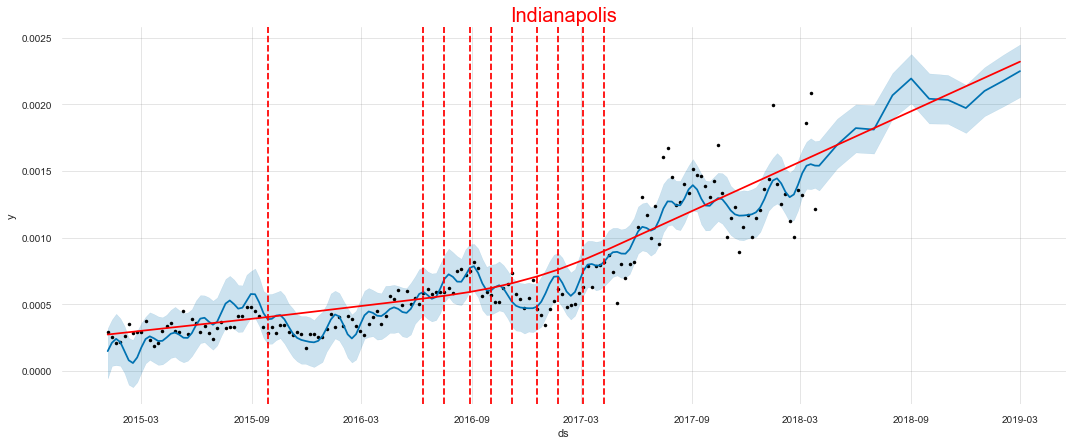

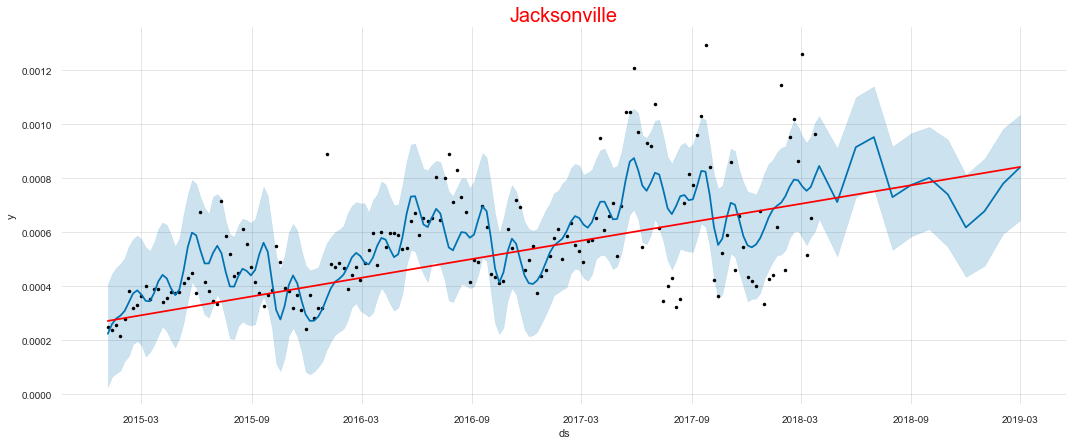

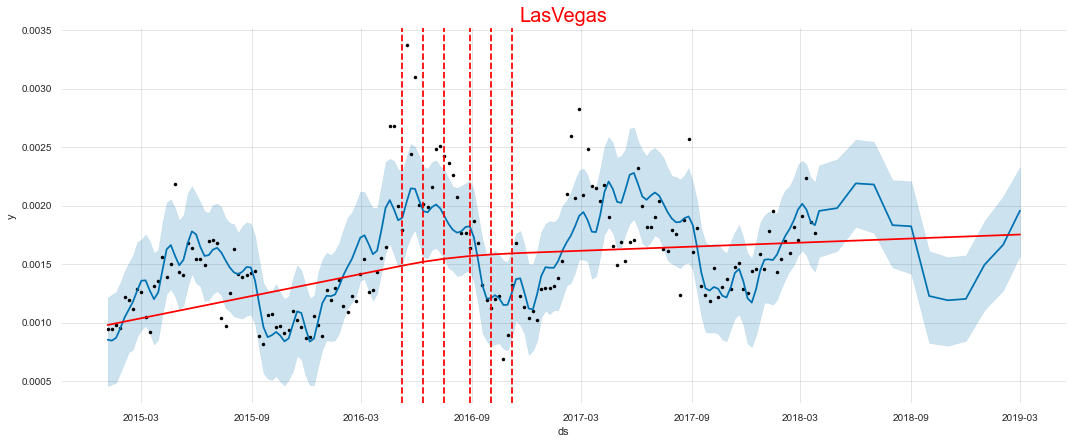

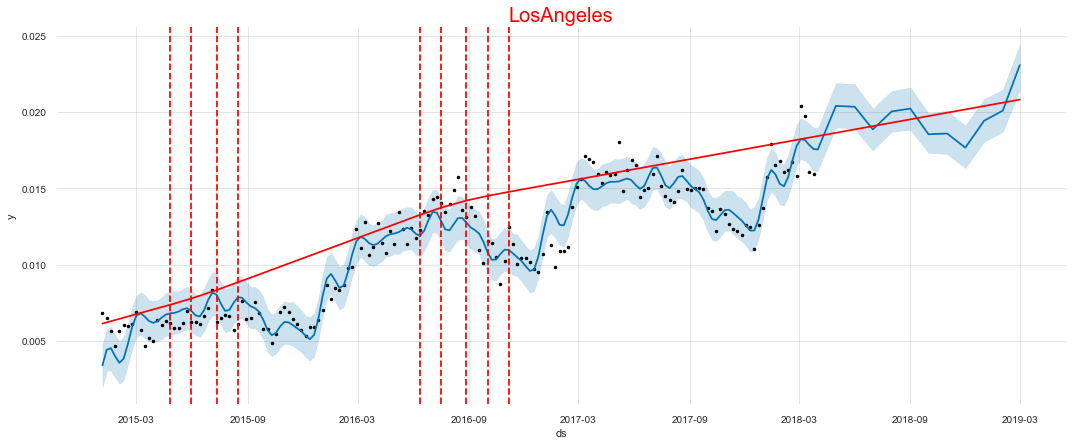

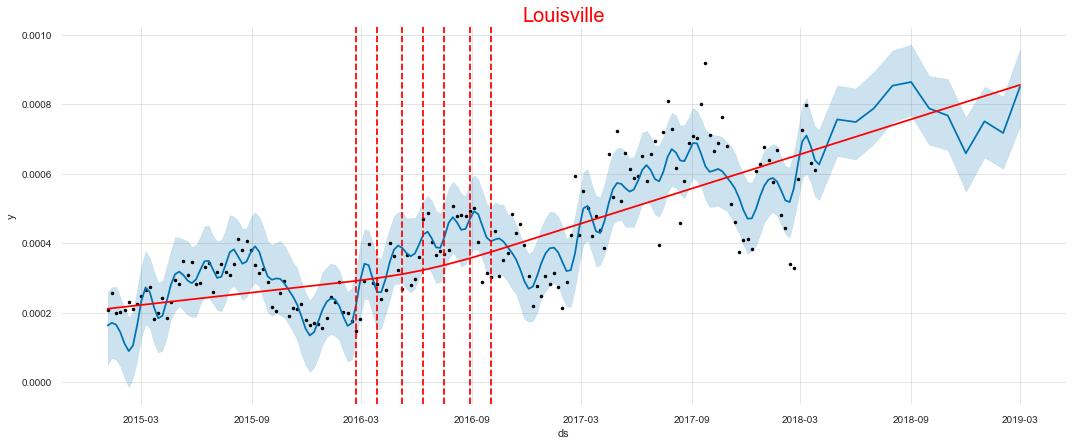

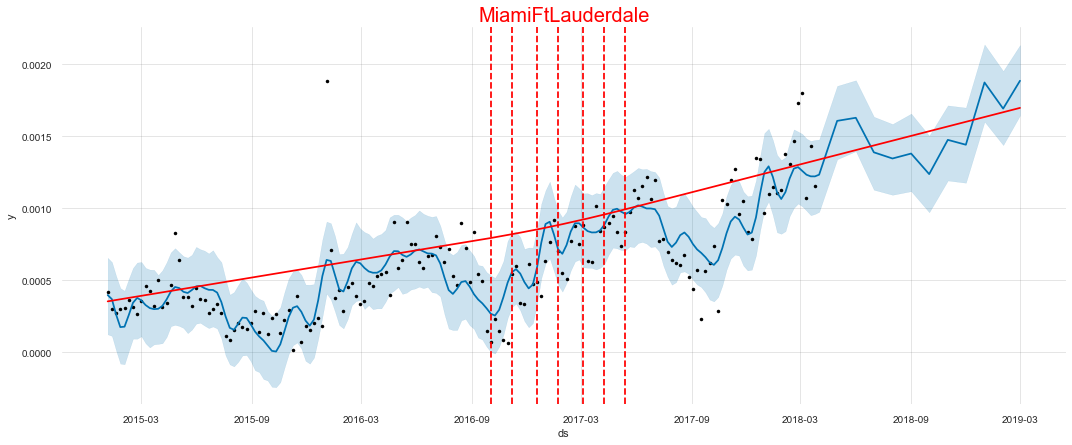

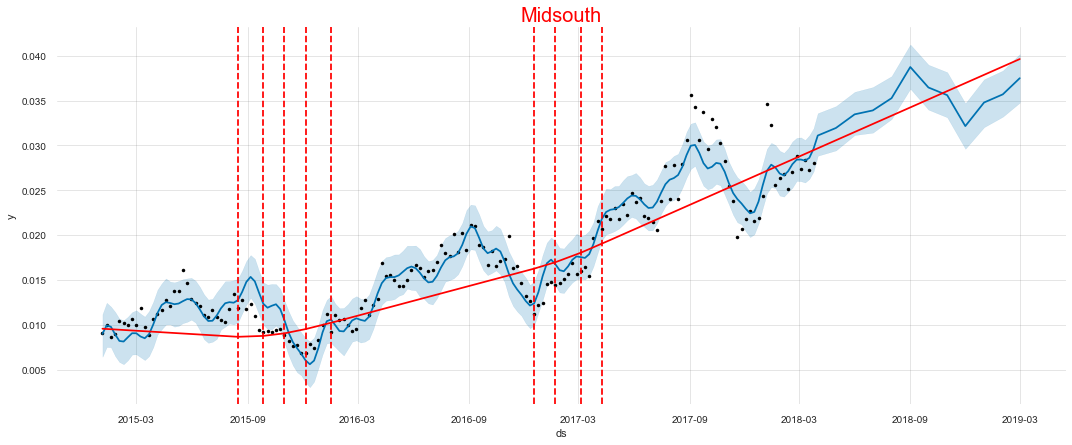

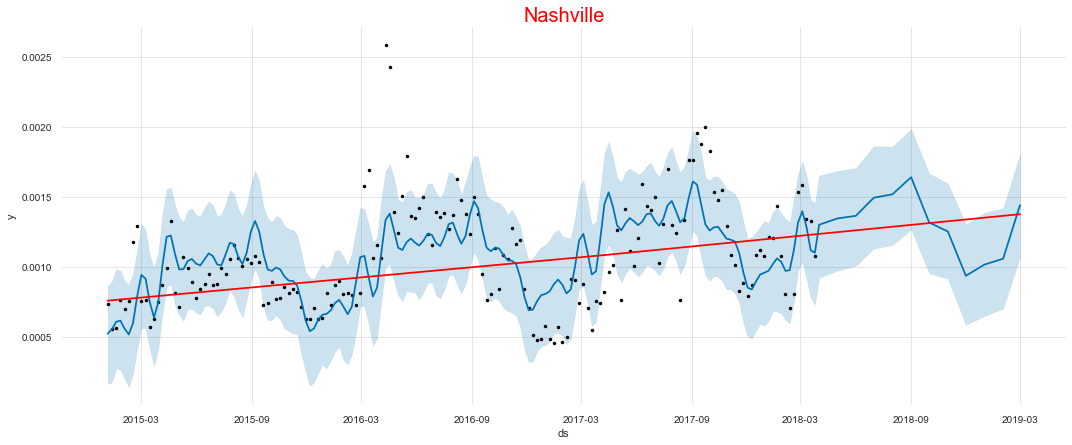

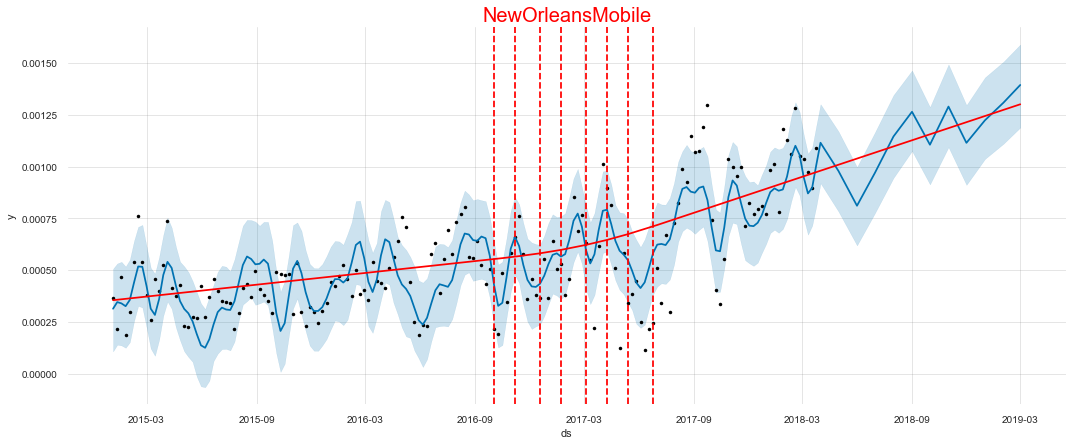

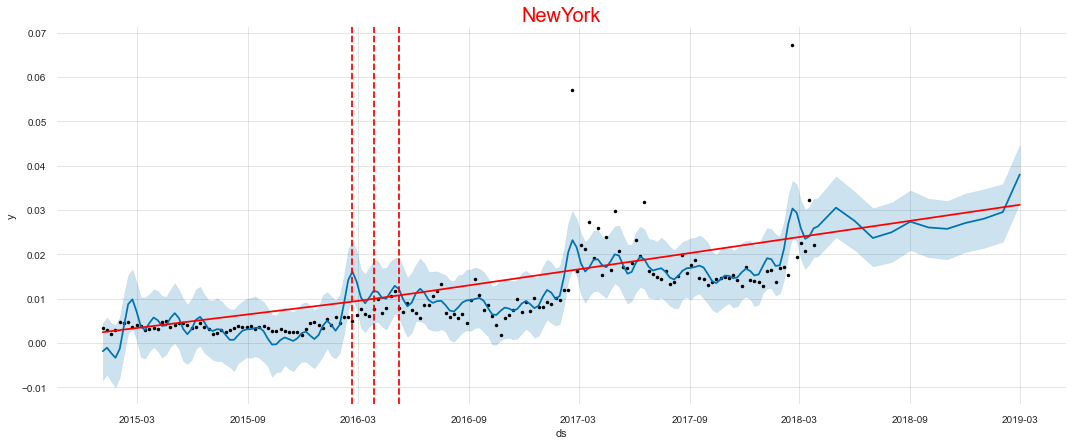

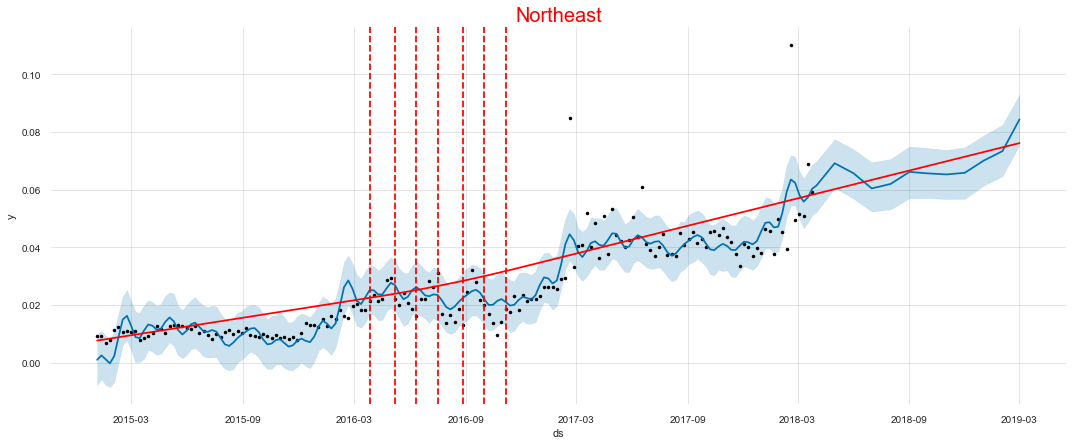

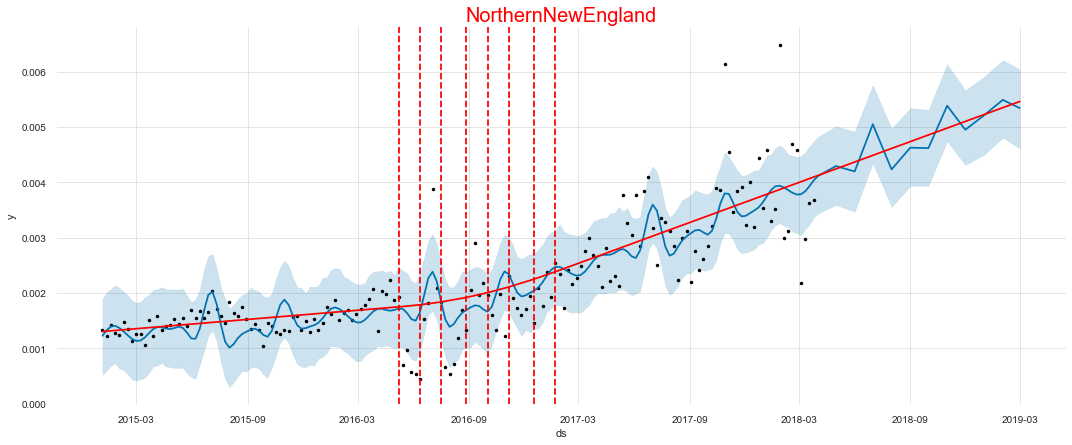

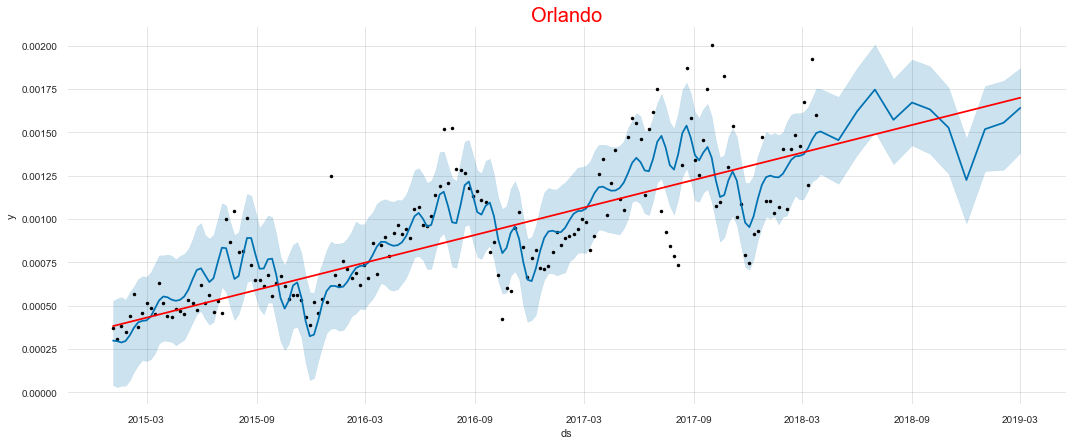

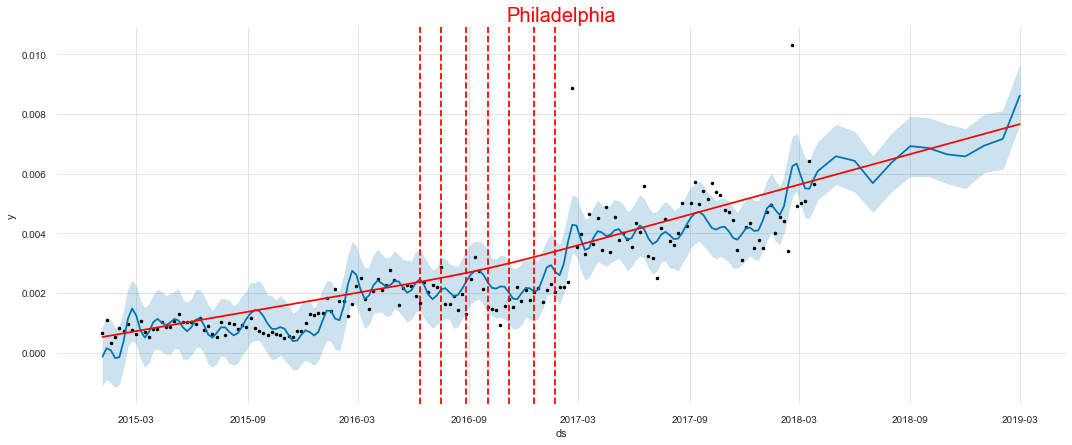

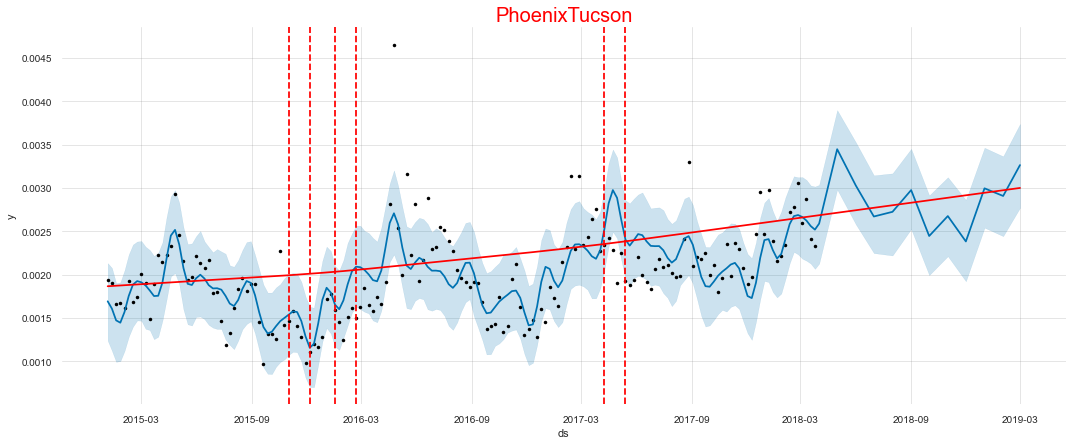

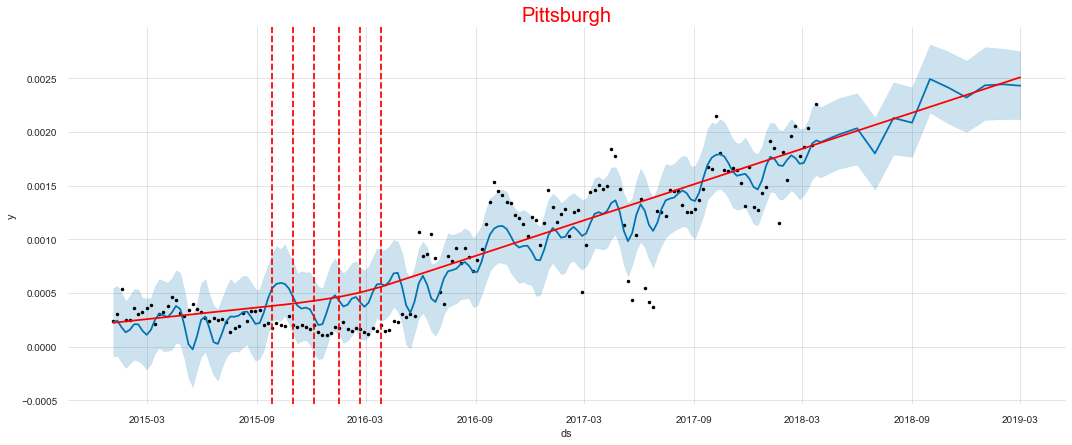

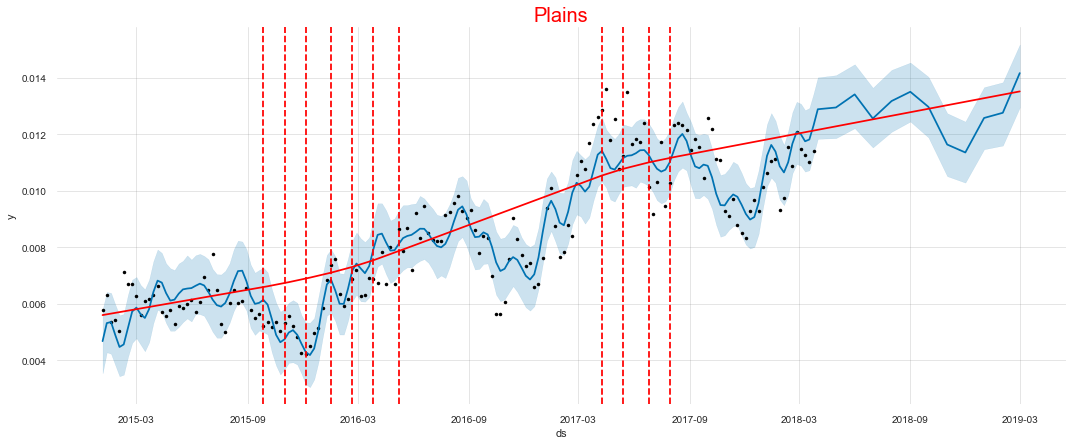

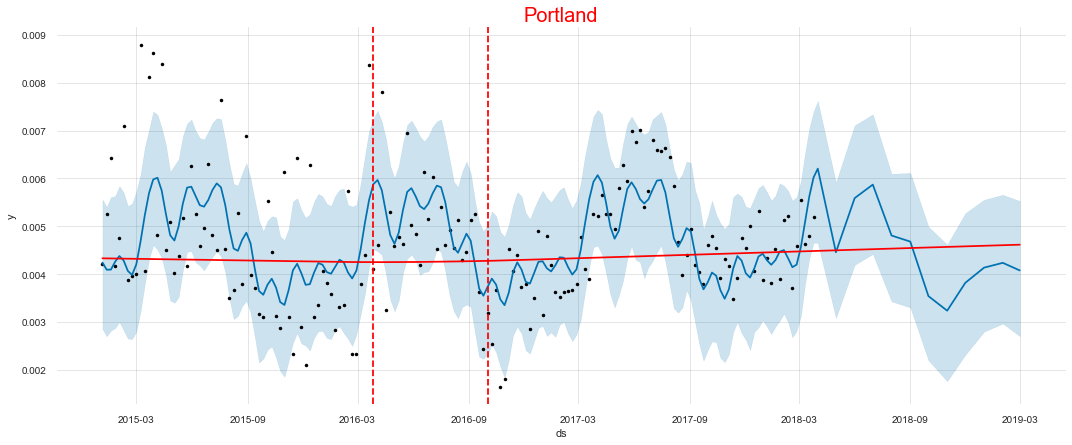

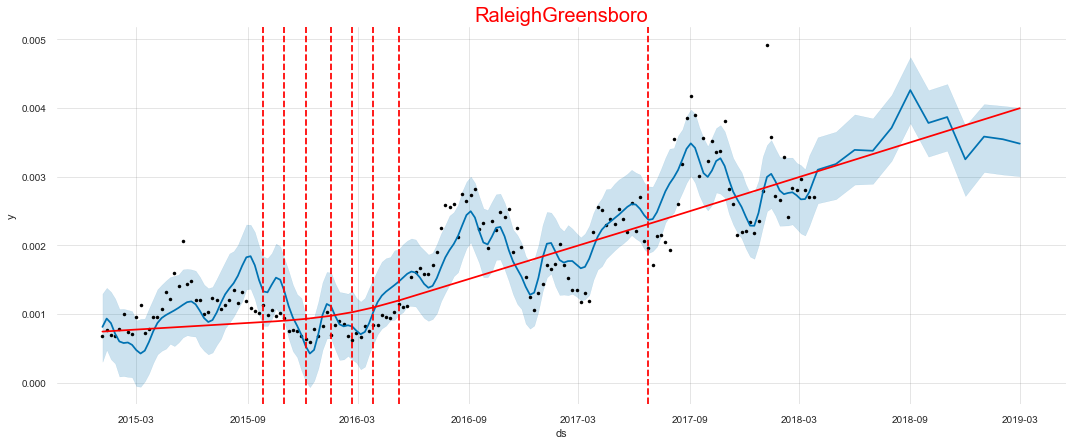

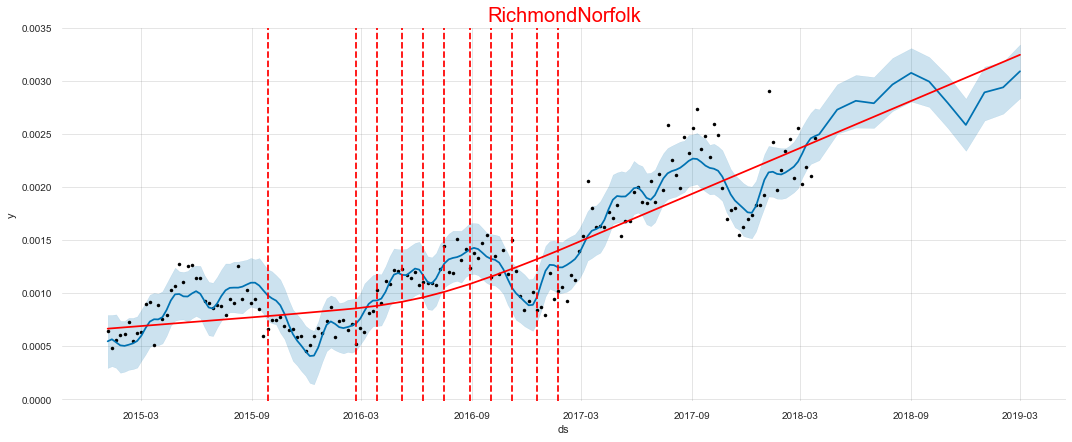

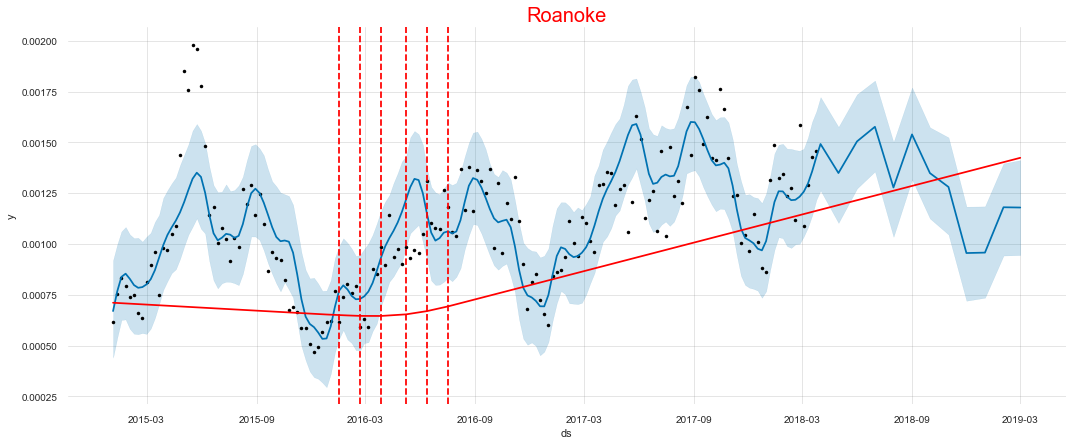

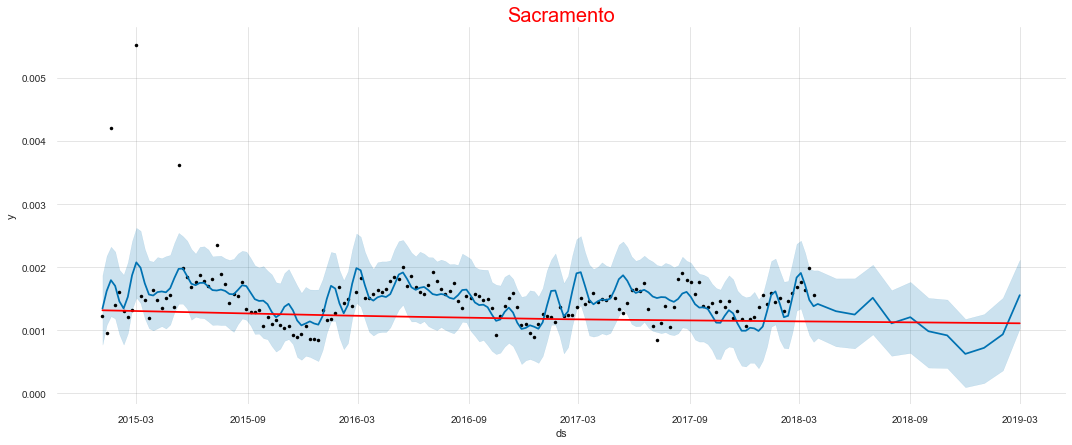

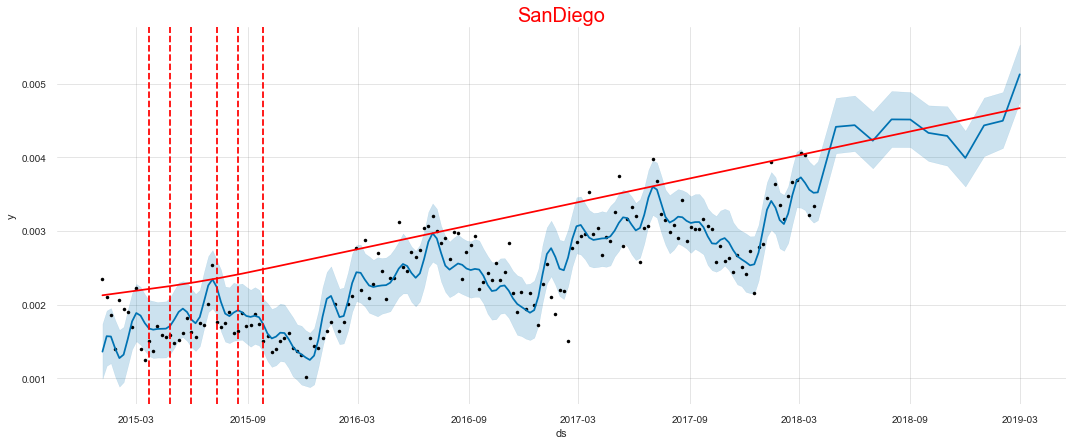

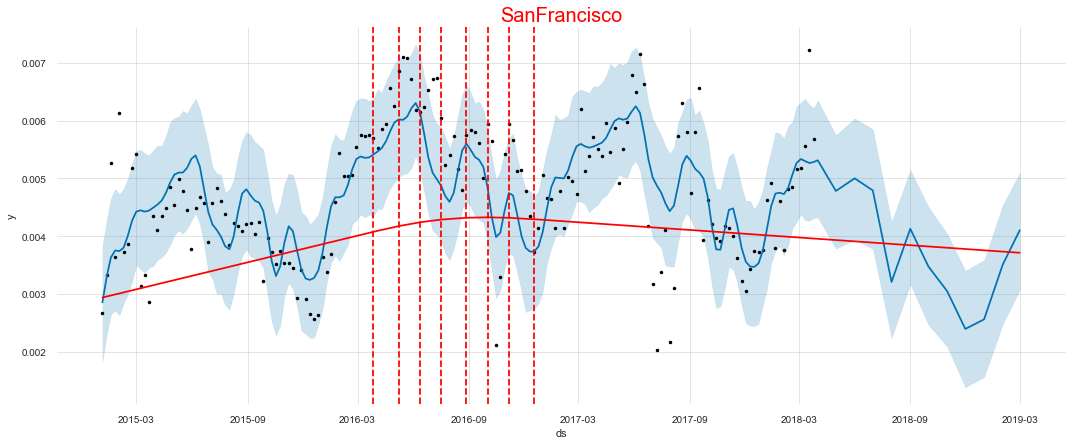

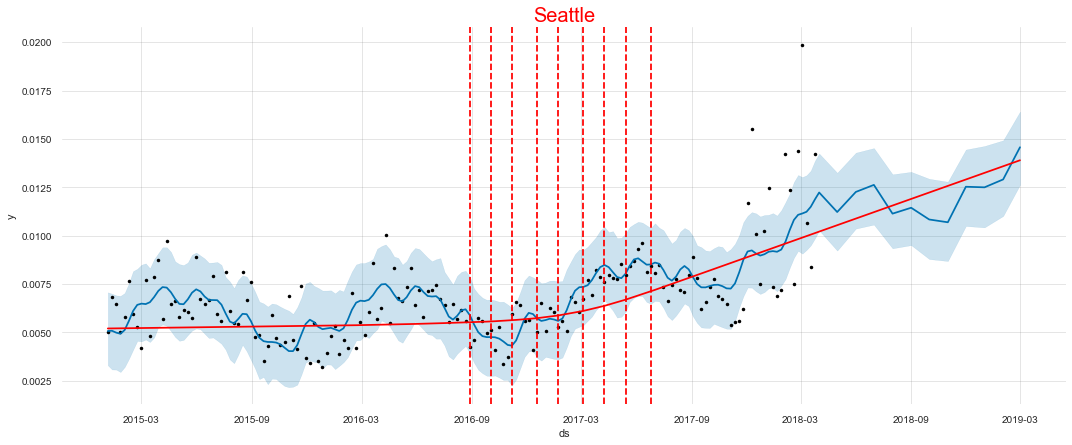

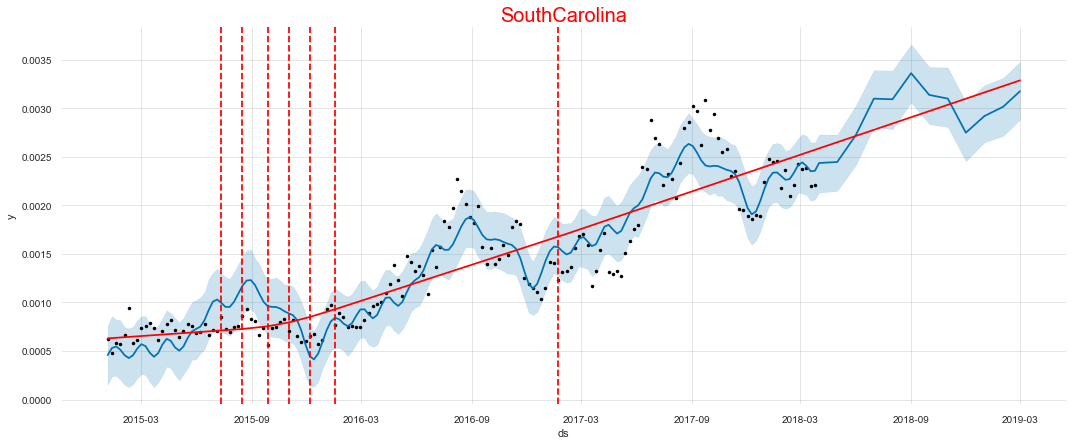

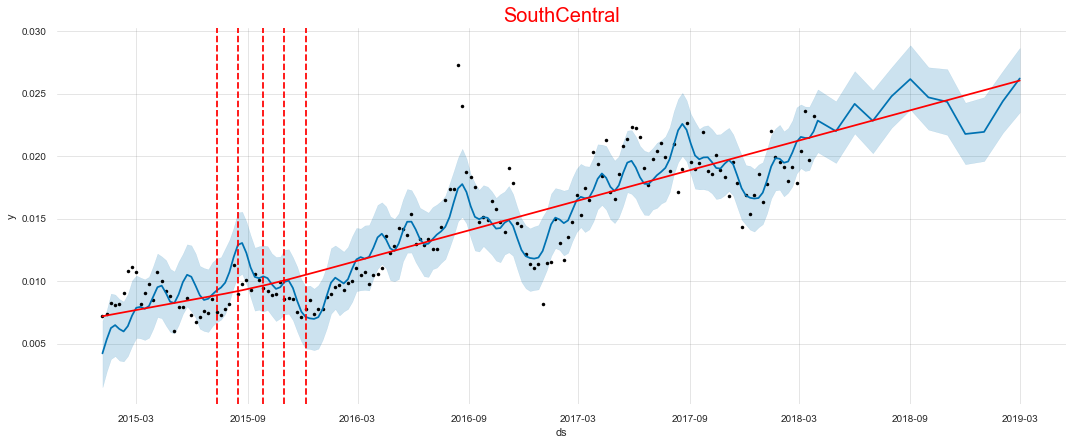

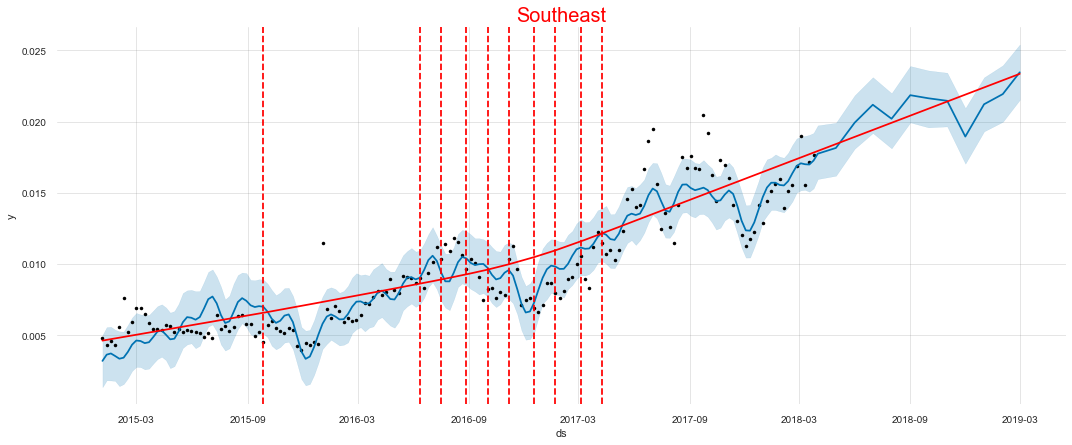

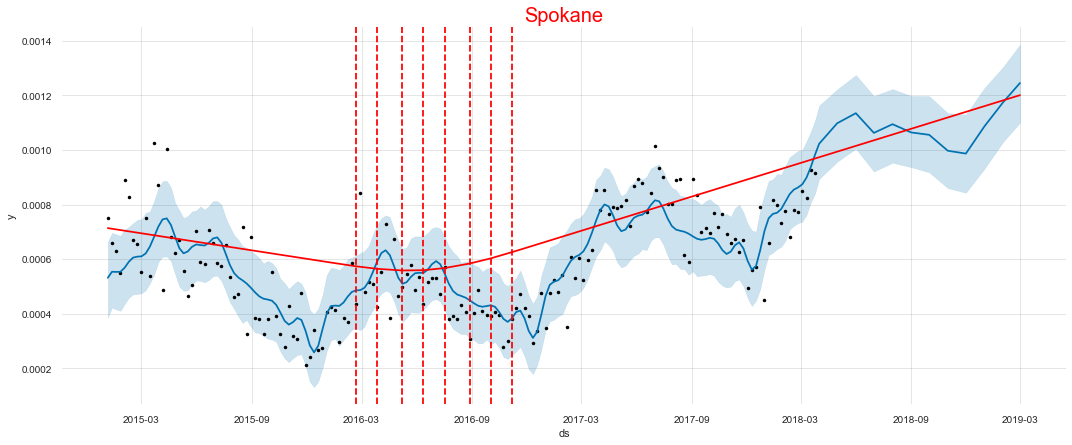

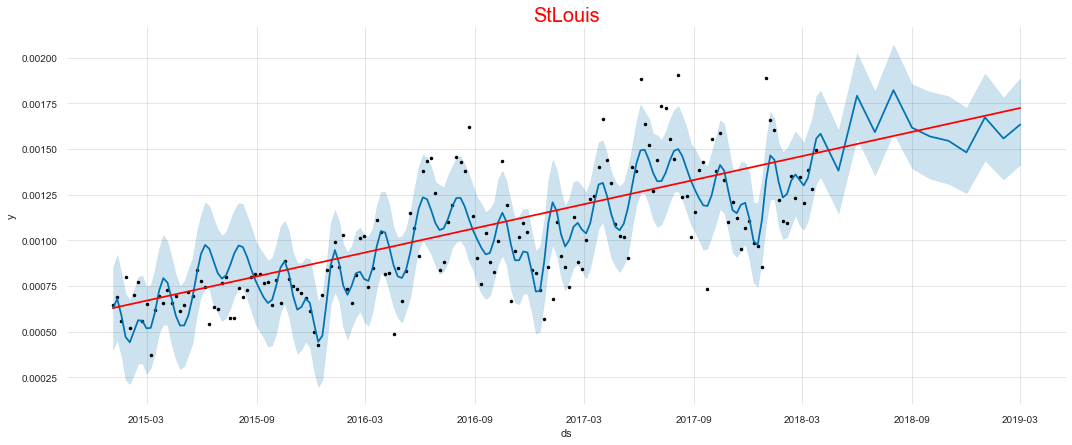

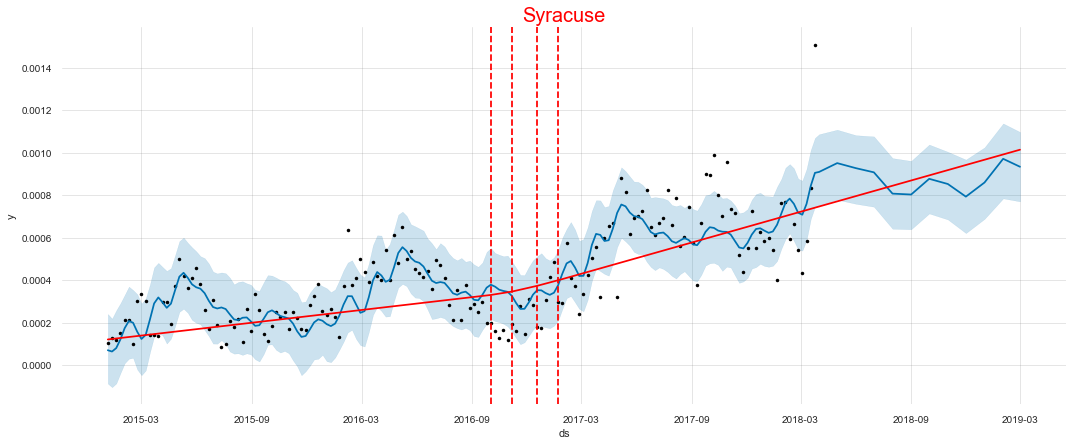

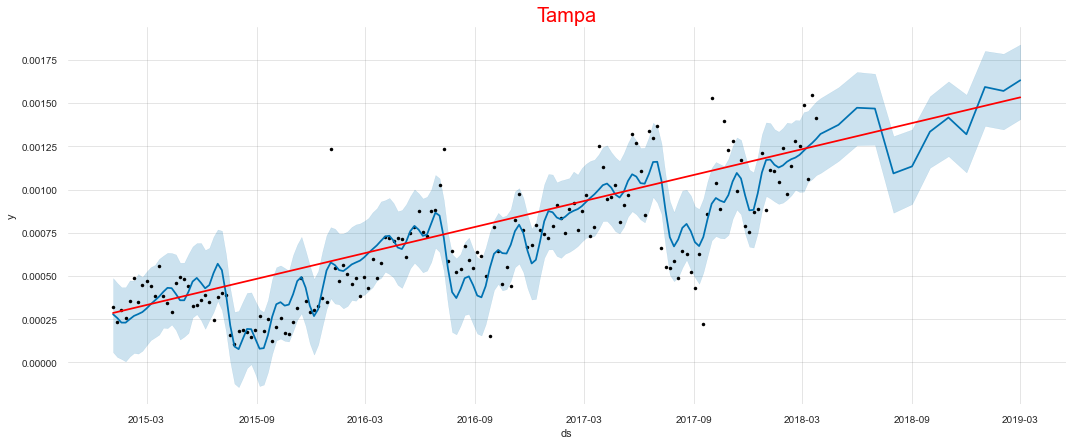

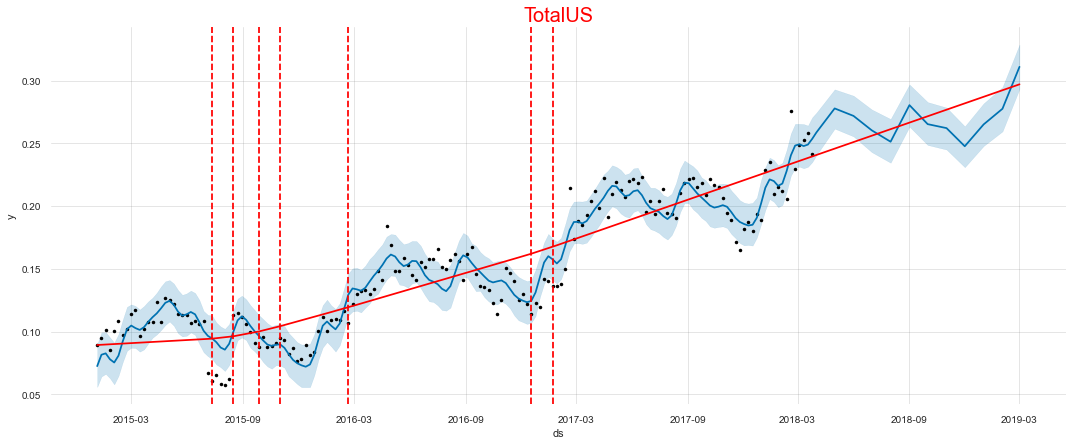

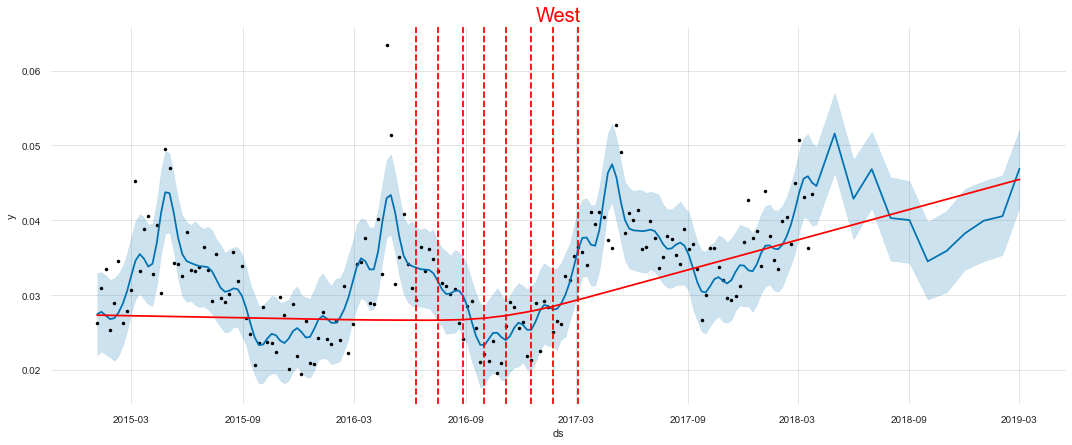

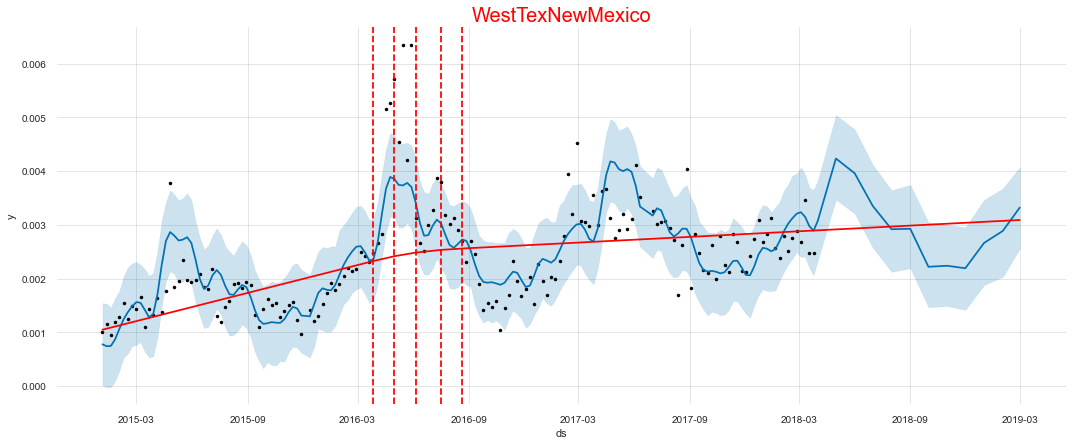

In [30]:
#quét tất cả region để tìm thị trường tiềm năng
for x in state:
    hass_future_forecast(data=df, state = x, hass_type='organic', y = 'AverageRevenue')


### Dựa trên trực quan hóa ta thấy có khá nhiều khu vực có xu hướng tăng về doanh thu trung bình trong năm sau, có thể chọn SanDiego để phát triển kinh doanh bơ organic vì mô hình bám khá sát với dữ liệu lịch sử và cho xu hướng tăng liên tục 

# Xây dựng mô hình dự đoán AveragePrice cho bơ organic tại SanDiego

### Data Preparation / Prepare

#### Các bước EDA đã làm ở bài toán trước không cần làm lại

In [31]:
df = data.copy()

In [32]:
df = df[(df['region'] == 'SanDiego') & (df['type'] == 'organic')]
df.head()

Date  AveragePrice  Total Volume    4046    4225  4770  Total Bags  \
0  2015-12-27          1.62       8704.72 1834.72 5181.54  0.00     1688.46   
1  2015-12-20          1.23      11727.34 1099.57 5048.80  0.00     5578.97   
2  2015-12-13          1.27      12242.29 1084.40 5007.42  3.24     6147.23   
3  2015-12-06          1.83       5564.87 1256.25 3763.92  0.00      544.70   
4  2015-11-29          1.87       7022.99 1232.37 5300.75  0.00      489.87   

   Small Bags  Large Bags  XLarge Bags     type  year    region  
0      472.88     1215.58         0.00  organic  2015  SanDiego  
1      592.32     4986.65         0.00  organic  2015  SanDiego  
2      674.51     5472.72         0.00  organic  2015  SanDiego  
3      541.37        3.33         0.00  organic  2015  SanDiego  
4      489.87        0.00         0.00  organic  2015  SanDiego

### Feature Engineering

có thể xem xét yếu tố mùa xuân hạ thu đông có ảnh hưởng đến AveragePrice
- mùa xuân: tháng 3,4,5
- mùa hạ: tháng 6,7,8
- mùa thu: tháng 9,10,11
- mùa đông: tháng 12,1,2

In [33]:
#chuyển dữ liệu biến Date về kiểu datetime
df['Date'] = pd.to_datetime(df['Date'])

In [34]:
#tạo ra cột Month
df['Month'] = pd.DatetimeIndex(df['Date']).month
df.head()

Date  AveragePrice  Total Volume    4046    4225  4770  Total Bags  \
0 2015-12-27          1.62       8704.72 1834.72 5181.54  0.00     1688.46   
1 2015-12-20          1.23      11727.34 1099.57 5048.80  0.00     5578.97   
2 2015-12-13          1.27      12242.29 1084.40 5007.42  3.24     6147.23   
3 2015-12-06          1.83       5564.87 1256.25 3763.92  0.00      544.70   
4 2015-11-29          1.87       7022.99 1232.37 5300.75  0.00      489.87   

   Small Bags  Large Bags  XLarge Bags     type  year    region  Month  
0      472.88     1215.58         0.00  organic  2015  SanDiego     12  
1      592.32     4986.65         0.00  organic  2015  SanDiego     12  
2      674.51     5472.72         0.00  organic  2015  SanDiego     12  
3      541.37        3.33         0.00  organic  2015  SanDiego     12  
4      489.87        0.00         0.00  organic  2015  SanDiego     11

In [35]:
def to_season(month):
    if month >= 3 and month <= 5:
        return 0
    elif month >= 6 and month <= 8:
        return 1
    elif month >= 9 and month <= 11:
        return 2
    else:
        return 3

In [36]:
#tạo ra cột Season
df['Season'] = df['Month'].apply(lambda x: to_season(x))

In [37]:
df.head()

Date  AveragePrice  Total Volume    4046    4225  4770  Total Bags  \
0 2015-12-27          1.62       8704.72 1834.72 5181.54  0.00     1688.46   
1 2015-12-20          1.23      11727.34 1099.57 5048.80  0.00     5578.97   
2 2015-12-13          1.27      12242.29 1084.40 5007.42  3.24     6147.23   
3 2015-12-06          1.83       5564.87 1256.25 3763.92  0.00      544.70   
4 2015-11-29          1.87       7022.99 1232.37 5300.75  0.00      489.87   

   Small Bags  Large Bags  XLarge Bags     type  year    region  Month  Season  
0      472.88     1215.58         0.00  organic  2015  SanDiego     12       3  
1      592.32     4986.65         0.00  organic  2015  SanDiego     12       3  
2      674.51     5472.72         0.00  organic  2015  SanDiego     12       3  
3      541.37        3.33         0.00  organic  2015  SanDiego     12       3  
4      489.87        0.00         0.00  organic  2015  SanDiego     11       2

In [38]:
#lựa chọn thuộc tính, bỏ đi các thuộc tính dư thừa
y = df['AveragePrice']
X = df.drop(['Date','AveragePrice','region','type','4046','4225','4770','Small Bags','Large Bags','XLarge Bags'], axis=1)

In [39]:
X.head()

Total Volume  Total Bags  year  Month  Season
0       8704.72     1688.46  2015     12       3
1      11727.34     5578.97  2015     12       3
2      12242.29     6147.23  2015     12       3
3       5564.87      544.70  2015     12       3
4       7022.99      489.87  2015     11       2

### Modeling & Evaluation / Analyze & Report

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Dùng Random Forest

In [41]:
pipe_RF = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor())])
pipe_RF.fit(X_train, y_train)
y_pred_RF = pipe_RF.predict(X_test)
mae_RF = mean_absolute_error(y_test, y_pred_RF)
r2_RF = r2_score(y_test, y_pred_RF)
train_RF = pipe_RF.score(X_train,y_train)
test_RF = pipe_RF.score(X_test,y_test)

#### Dùng XGBRegressor

In [42]:
pipe_XGB = Pipeline([('scaler', StandardScaler()), ('xgb', XGBRegressor())])
pipe_XGB.fit(X_train, y_train)
y_pred_XGB = pipe_XGB.predict(X_test)
mae_XGB = mean_absolute_error(y_test, y_pred_XGB)
r2_XGB = r2_score(y_test, y_pred_XGB)
train_XGB = pipe_XGB.score(X_train,y_train)
test_XGB = pipe_XGB.score(X_test,y_test)

#### Dùng BaggingRegressor

In [43]:
# importing bagging module
from sklearn.ensemble import BaggingRegressor
import xgboost as xgb

In [44]:
pipe_BAG = Pipeline([('scaler', StandardScaler()), ('bag', BaggingRegressor(base_estimator=xgb.XGBRegressor()))])
pipe_BAG.fit(X_train, y_train)
y_pred_BAG = pipe_BAG.predict(X_test)
mae_BAG = mean_absolute_error(y_test, y_pred_BAG)
r2_BAG = r2_score(y_test, y_pred_BAG)
train_BAG = pipe_BAG.score(X_train,y_train)
test_BAG = pipe_BAG.score(X_test,y_test)

In [45]:
scoring = pd.DataFrame({"algorithm":['RandomForestRegressor', 'XGBRegressor', 'BaggingRegressor'],
                        "score train":[train_RF, train_XGB, train_BAG], 
                        "score test":[test_RF, test_XGB, test_BAG],
                        "R2 score":[r2_RF, r2_XGB, r2_BAG],
                        "MAE":[mae_RF, mae_XGB, mae_BAG]})
scoring

algorithm  score train  score test  R2 score  MAE
0  RandomForestRegressor         0.97        0.83      0.83 0.10
1           XGBRegressor         1.00        0.82      0.82 0.11
2       BaggingRegressor         0.97        0.78      0.78 0.11

In [46]:
y.mean()

1.7348520710059172

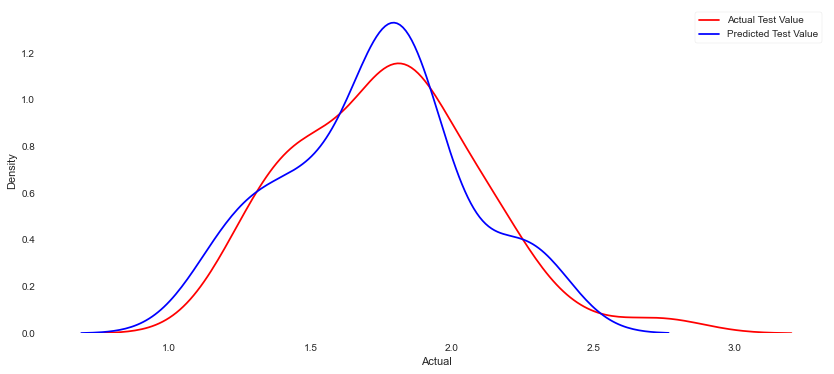

In [48]:
#trục quan hóa dữ liệu
final = pd.DataFrame({'Actual': y_test.values, 
                   'Prediction': pd.DataFrame(y_pred_RF)[0].values}) 

plt.figure(figsize=(14,6))
ax1 = sns.kdeplot(final['Actual'], color='r', label='Actual Test Value')
sns.kdeplot(final['Prediction'], color='b', label='Predicted Test Value', ax=ax1)
plt.legend()
plt.show()

### Kết luận:
<b style="color:blue">Đối với Organic Avocado tại SanDiego, RandomForestRegressor cho kết quả R2 cao nhất đại 83% và mức độ overfitting thấp nhất trong 3 mô hình, với MAE cũng thấp hơn các mô hình còn lại (khoảng 6% so với mean của dữ liệu), biểu đồ cũng cho thấy mô hình dự đoán gần sát với thực tế => sử dụng RandomForestRegressor để dự đoán giá Organic Avocado tại SanDiego</b>